* The following code is modified based on the original torchcv project. 
* We are going to use PASACAL VOC12 as dataset.
* You could donwload VOC2012 
  train/validation: http://host.robots.ox.ac.uk/pascal/VOC/voc2012/#devkit
* test data: https://pjreddie.com/projects/pascal-voc-dataset-mirror/


In [36]:
import os
import random
import argparse
import matplotlib.pyplot as plt
from PIL import Image,ImageDraw
from IPython.display import display

from time import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as T

from __future__ import print_function
from dbpn import Net as DBPN
from dbpn import get_eval_set
from dbpn import get_pair_set
from ssd import SSD
from ssd import build_ssd
from ssd.layers.modules import MultiBoxLoss
from ssd.data.config import voc
from ssd.data import detection_collate
from ssd.data import VOCAnnotationTransform, VOCDetection, BaseTransform, SRDetection
from torchcv.models.ssd import SSDBoxCoder
import cv2
from metric import *
import matplotlib.pyplot as plt
%matplotlib inline

import sys; sys.argv=['']; del sys


In [37]:
# Arguments & settings
parser = argparse.ArgumentParser(description='PyTorch Super Resolution Detection Networks')
parser.add_argument('--upscale_factor', type=int, default=4, help="super resolution upscale factor")
parser.add_argument('--testBatchSize', type=int, default=1, help='testing batch size')
parser.add_argument('--batch_size', type=int, default=1, help='training batch size') # GPU: 9GB!
parser.add_argument('--threads', type=int, default=1, help='number of threads for data loading')
parser.add_argument('--seed', type=int, default=123, help='random seed to use. Default=123')
parser.add_argument('--gpu_mode', type=bool, default=True)
parser.add_argument('--gpus', default=1, type=float, help='number of gpu')
parser.add_argument('--test_dataset', type=str, default='VOC12-LR-X8-test')
#parser.add_argument('--sr_dataset', type=str, default='VOC12-SR-X8')
parser.add_argument('--eval_dataset', type=str, default='VOC12-LR-x4')
parser.add_argument('--train_dataset', type=str, default='VOC12-LR-x4')
parser.add_argument('--hr_dataset', type=str, default='VOC12-HR300')
parser.add_argument('--anno_path', type=str, default='Annotations')
parser.add_argument('--imSetpath', type=str, default='ImageSets')
parser.add_argument('--input_dir', type=str, default='./dataset')
parser.add_argument('--output', default='./dataset/results', help='Location to save some outputs')
parser.add_argument('--checkpt', default='./checkpoint', help='Location to save checkpoint models')
parser.add_argument('--lr', type=float, default=1e-4, help='Learning Rate. Default=0.0001')
parser.add_argument('--nEpochs', type=int, default=5, help='number of epochs to fine tune net S over target loss')

opt = parser.parse_args()

gpus_list=range(opt.gpus)
print(opt)



Namespace(anno_path='Annotations', batch_size=1, checkpt='./checkpoint', eval_dataset='VOC12-LR-x4', gpu_mode=True, gpus=1, hr_dataset='VOC12-HR300', imSetpath='ImageSets', input_dir='./dataset', lr=0.0001, nEpochs=5, output='./dataset/results', seed=123, testBatchSize=1, test_dataset='VOC12-LR-X8-test', threads=1, train_dataset='VOC12-LR-x4', upscale_factor=4)


In [38]:
print('===> Loading net S fine-tune training datasets')

# VOC0712 dataset mean
MEANS = (104, 117, 123)

sd_dataset = SRDetection(root='./dataset', image_sets='trainval.txt', data_mean = MEANS,
                         target_transform = VOCAnnotationTransform())

sd_data_loader = DataLoader(dataset=sd_dataset, batch_size=opt.batch_size, num_workers=opt.threads,
                            shuffle=False, collate_fn=detection_collate, pin_memory=True)


===> Loading net S fine-tune training datasets


In [39]:
# TODO:
# 1. come up with test/eval functions
# 2. come up with visualization image

class DBPN2SSD(nn.Module):
    
    def __init__(self, s_model_name, d_model_name, d_frozen):
        super(DBPN2SSD, self).__init__()
        self.supervis = DBPN(num_channels=3, base_filter=64, feat=256, num_stages=7, scale_factor=4)
        if os.path.exists(s_model_name):
            self.supervis = torch.nn.DataParallel(self.supervis, device_ids=gpus_list)
            self.supervis.load_state_dict(torch.load(s_model_name, map_location=lambda storage, loc: storage))

        # self.detector = SSD(), setup ssd as 'train' mode for gradient flow
        # later at test/eval situation, we will overwrite it's mode to 'test'
        self.detector = build_ssd('test', 300, 21)
        if os.path.exists(d_model_name):
            self.detector.load_state_dict(torch.load(d_model_name, map_location=lambda storage, loc: storage))
        if d_frozen:
            for param in self.detector.parameters():
                param.requires_grad = False
            for param in self.supervis.parameters():
                param.requires_grad = False
                
        
    def forward(self, x):
        superx = self.supervis(x)
        sr = superx
        # current detector: SSD300, so assume superx: 300x300!
        detect = self.detector(superx)
        return (sr, detect)


    

In [46]:
labelmap = (  # always index 0
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor')

COLORS = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
FONT = cv2.FONT_HERSHEY_SIMPLEX

def save_img(img, img_name):
    save_img = img.squeeze().clamp(0, 1).numpy().transpose(1,2,0)

    # save img
    save_dir=os.path.join(opt.output,opt.test_dataset)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    save_fn = save_dir +'/'+ img_name
    cv2.imwrite(save_fn, cv2.cvtColor(save_img*255, cv2.COLOR_BGR2RGB),  [cv2.IMWRITE_PNG_COMPRESSION, 0])

    
def eval():

    net = DBPN2SSD('dbpn/models/VOC12-LR-x4-DBPN-ep100.pth', 'ssd/weights/ssd300_mAP_77.43_v2.pth', True)
    net.eval()
    
    pred_boxes = []
    pred_labels = []
    pred_scores = []
    gt_boxes = []
    gt_labels = []


    for iteration, batch in enumerate(sd_data_loader, 1):
        
        # input is LR image; sr_target is pseudo (300x300) original HR image, det_target is bboxes
        # input, sr_target = batch[0], batch[1]
        input, sr_target, det_target = batch[0], batch[1], batch[2]


        input_v = Variable(input, volatile=True)
        sr_target_v = Variable(sr_target, volatile=True)

        ssd_target = det_target[0].numpy()
        sr_img, ssd_out = net(input_v)
        ssd_out = net.detector(sr_target_v)

        save_img(sr_img.data,"test.jpeg")

        img = Image.open("./dataset/VOC12-LR-x4/2007_000661.jpg").convert('RGB')
        #out_dbpn = net.supervis(torch.from_numpy(img))
        
        #out_dbpn = out_dbpn.squeeze().numpy().transpose(1,2,0)
        #plt.imshow(out_dbpn.astype(np.uint8))
        #plt.show()         
        
        #print("\nimg_sr",img_sr)
        # create PSNR/SSIM
        img_input = input.squeeze().numpy().transpose(1,2,0)
        img_input = img_input*255
        img_input = np.clip(img_input, 0, 255)
        #s_img = Image.fromarray(img_input, 'RGB')
        plt.imshow(img_input.astype(np.uint8))
        plt.show()       
        
        sr_img = (sr_img - sr_img.min())/(sr_img.max() - sr_img.min())
        img_dbpn = sr_img.squeeze().numpy().transpose(1,2,0)
        #
        img_dbpn = img_dbpn * 255
        img_dbpn = np.clip(img_dbpn, 0, 255)

        plt.imshow(img_dbpn.astype(np.uint8))
        plt.show()   
        
        #s_img = img_input.resize((300,300),Image.BICUBIC) 
        target = sr_target.squeeze().numpy().transpose(1,2,0)
        ssim = metric_ssim(target,img_dbpn)
        psnr = metric_psnr(target,img_dbpn)

        # Get the target box and lables
        print("ssim, psnr",ssim,psnr)
        
        label_targets = ssd_target[:][-1]
        topleft = ssd_target[:][0:2]*300
        bottomright = ssd_target[:][2:4]*300
        
        for i in range(topleft.shape[0]):
            print(label_targets,topleft,bottomright)
            #print("box_targets:(%d, %d),(%d, %d)" % (topleft[i][0],topleft[i][1],bottomright[i][2],\
            #                               bottomright[i][3]),"label_targets:",label_targets)
        

        im_target = sr_target.squeeze().numpy().transpose(1,2,0)
        im_target = im_target
        im_target = np.clip(im_target, 0, 255)
        
        

        detections = ssd_out.data
        
        # scale each detection back up to the image
        scale = torch.Tensor([300, 300,
                             300,300])

        pred_num = 0
        for i in range(detections.size(1)):
            j = 0
            #print("%.4f" % detections[0, i, j, 0])
            while detections[0, i, j, 0] >= 0.6:
                score = detections[0, i, j, 0]
                label_name = labelmap[i-1]
                pt = (detections[0, i, j, 1:]*scale).cpu().numpy()
                coords = (pt[0], pt[1], pt[2], pt[3])
                print("coords",coords,score,label_name)
                
                cv2.rectangle(img_dbpn, (pt[0], pt[1]), (pt[2], pt[3]), COLORS[i % 3], 2)
                cv2.putText(img_dbpn, label_name, (int(pt[0]), int(pt[1])-4),
                            FONT, 0.6, (255, 0, 0), 2, cv2.LINE_AA)
                pred_num += 1
                j += 1
                

        print("topleft",topleft,"bottomright",bottomright)

        plt.imshow(img_dbpn.astype(np.uint8))
        plt.show()

        plt.imshow(im_target.astype(np.uint8))
        plt.show()


        break
        



/home/tos/coursework/cs231n/cs231x/super-resolution-detection/dbpn/dbpn.py:47: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  torch.nn.init.kaiming_normal(m.weight)
/home/tos/coursework/cs231n/cs231x/super-resolution-detection/dbpn/dbpn.py:51: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  torch.nn.init.kaiming_normal(m.weight)
/home/tos/coursework/cs231n/cs231x/super-resolution-detection/ssd/ssd.py:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.priors = Variable(self.priorbox.forward(), volatile=True)
/home/tos/coursework/cs231n/cs231x/super-resolution-detection/ssd/layers/modules/l2norm.py:17: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(self.weight,self.gamma)
__main__:42: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
__main__:43: UserWarn

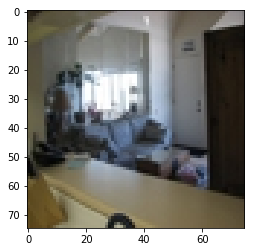

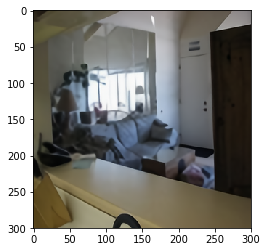

ssim, psnr 0.9631586987790238 25.17701
[0.264      0.42133334 0.356      0.5226667  8.        ] [[  70.8      140.8      198.00002  221.59999 5100.     ]
 [  38.4       71.2      101.4      156.8     4500.     ]] [[  79.2  126.4  106.8  156.8 2400. ]]
[0.264      0.42133334 0.356      0.5226667  8.        ] [[  70.8      140.8      198.00002  221.59999 5100.     ]
 [  38.4       71.2      101.4      156.8     4500.     ]] [[  79.2  126.4  106.8  156.8 2400. ]]
coords (37.51063, 70.763626, 101.56081, 154.05176) tensor(0.8970) pottedplant
coords (58.965622, 141.05049, 201.29282, 223.78918) tensor(0.9969) sofa
topleft [[  70.8      140.8      198.00002  221.59999 5100.     ]
 [  38.4       71.2      101.4      156.8     4500.     ]] bottomright [[  79.2  126.4  106.8  156.8 2400. ]]


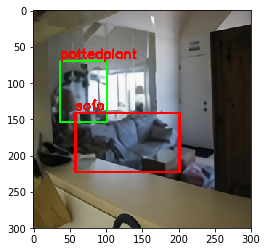

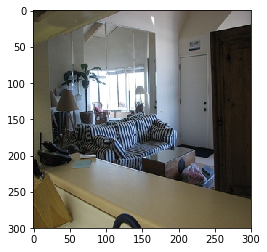

In [47]:
eval()
    


In [7]:
torch.cuda.empty_cache()


### Debugging code below, no need to run :)

In [8]:
print(' YOU Donot need to run this ===> Loading some datasets')

lr_path = os.path.join(opt.input_dir, opt.train_dataset)
hr_path = os.path.join(opt.input_dir, opt.hr_dataset)

fine_train_set = get_pair_set(lr_path, hr_path)
train_data_loader = DataLoader(dataset=fine_train_set, num_workers=opt.threads, \
                               batch_size=opt.testBatchSize, shuffle=False)


 YOU Donot need to run this ===> Loading some datasets


In [9]:
print(' YOU Donot need to run this ===> Loading some datasets')

lr_path = os.path.join(opt.input_dir, opt.eval_dataset)
hr_path = os.path.join(opt.input_dir, opt.hr_dataset)

eval_set = get_pair_set(lr_path, hr_path)
eval_data_loader = DataLoader(dataset=eval_set, num_workers=opt.threads, \
                               batch_size=opt.testBatchSize, shuffle=False)


 YOU Donot need to run this ===> Loading some datasets
